# Data Inspection

download `train_parsed_words.csv` first : [download link](https://drive.google.com/file/d/1MVYCX5xXBp9HCwRUNuGB2zWQvroAE67_/view?usp=sharing)

In [1]:
import os
import logging

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Basic Config

# Constants
DATA_PATHNAME = './train_parsed_words.csv'

# Logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
stream_handler = logging.StreamHandler()
stream_handler.setFormatter(logging.Formatter('%(asctime)s [%(levelname)s] %(message)s'))
logger.addHandler(stream_handler)

# Pandas
pd.options.display.max_columns = None
pd.set_option('precision', 2)
pd.options.display.float_format = '{:.2f}'.format

# Visualization
%matplotlib inline
sns.set()

# Current directory
print(f"Current directory is {os.getcwd()}")

Current directory is /home/rokong/Repository/sentiment_analysis_nb


In [2]:
df_data = pd.read_csv(DATA_PATHNAME)
df_data.head()

,score,text
0,3,like
1,3,funchuck
2,3,gave
3,3,dad
4,3,gag


## Overall Distribution Of Pos/Neg ratio

In [3]:
df_dist = df_data.copy()

def label_score(score):
    if score == 3:
        return 1   # Neutral (1)
    else:
        return 2 if score > 3 else 0 # Negative(0), Posivite(2)

# Label whether it is positive or negative
df_dist['label'] = df_dist['score'].apply(label_score)

df_dist.head()

,score,text,label
0,3,like,1
1,3,funchuck,1
2,3,gave,1
3,3,dad,1
4,3,gag,1


In [4]:
# Pivoting
df_dist = pd.pivot_table(df_dist, values='score', index='text',
                    columns='label', aggfunc='count', fill_value=0)

# Change column names
df_dist.columns.name = ''
df_dist.rename(columns={0: 'neg', 1: 'neu', 2: 'pos'}, inplace=True)

# Remove noises
df_dist = df_dist[df_dist['pos']+df_dist['neu']+df_dist['neg'] > 100]

df_dist.head()

,neg,neu,pos
text,,,
abilities,38,28,54
ability,185,122,301
able,1013,538,1080
abridged,92,45,36
absolute,198,43,186


In [5]:
def calc_ratio(label_name):
    df_dist[f'{label_name}_ratio'] = (df_dist[label_name]
                                      / (df_dist['neg']+df_dist['neu']+df_dist['pos'])).round(3)

# Calculate the ratio
for label_name in df_dist.columns.tolist():
    calc_ratio(label_name)

df_dist.head()

,neg,neu,pos,neg_ratio,neu_ratio,pos_ratio
text,,,,,,
abilities,38,28,54,0.32,0.23,0.45
ability,185,122,301,0.30,0.20,0.49
able,1013,538,1080,0.39,0.20,0.41
abridged,92,45,36,0.53,0.26,0.21
absolute,198,43,186,0.46,0.10,0.44


In [6]:
df_dist.drop(columns=['neg', 'neu', 'pos'], inplace=True)
df_dist.reset_index(inplace=True)
df_dist.head()

,text,neg_ratio,neu_ratio,pos_ratio
0,abilities,0.32,0.23,0.45
1,ability,0.30,0.20,0.49
2,able,0.39,0.20,0.41
3,abridged,0.53,0.26,0.21
4,absolute,0.46,0.10,0.44


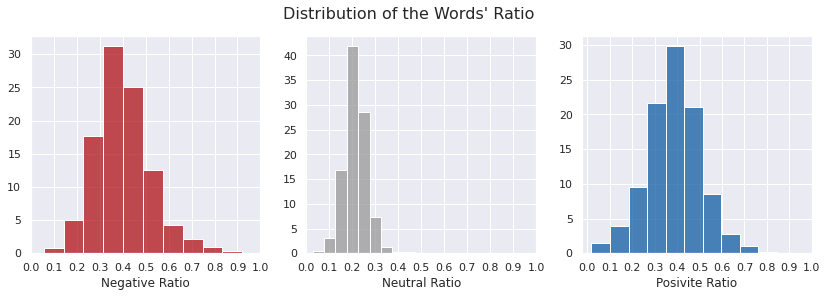

In [7]:
# Visualize in histogram
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))

fig.suptitle("Distribution of the Words' Ratio", fontsize=16)

# Negative
sns.histplot(data=df_dist[['text', 'neg_ratio']], x='neg_ratio',
             stat='percent', ax=ax0, bins=10,
             color=sns.color_palette('Reds', n_colors=5)[4])
ax0.set_xlabel('Negative Ratio')
ax0.set_ylabel(None)
ax0.set_xticks(np.arange(0, 1.1, 0.1))

# Neutral
sns.histplot(data=df_dist[['text', 'neu_ratio']], x='neu_ratio',
             stat='percent', ax=ax1, bins=10,
             color=(0.6, 0.6, 0.6))
ax1.set_xlabel('Neutral Ratio')
ax1.set_ylabel(None)
ax1.set_xticks(np.arange(0, 1.1, 0.1))

# Positive
sns.histplot(data=df_dist[['text', 'pos_ratio']], x='pos_ratio',
             stat='percent', ax=ax2, bins=10,
             color=sns.color_palette('Blues', n_colors=5)[4])
ax2.set_xlabel('Posivite Ratio')
ax2.set_ylabel(None)
ax2.set_xticks(np.arange(0, 1.1, 0.1))

plt.show()

# Save as a transparent image
fig.savefig('density_of_words.png', transparent=True)

## The Most Frequent Positive/Negative Word

In [8]:
def show_frequent_words(word_list, is_pos):
    df_words = df_data.copy()

    # Filtering the words
    df_words = df_words[df_words['text'].isin(word_list)]

    df_words.reset_index(inplace=True)
    df_words.drop(columns='index', inplace=True)

    # 100% for each text
    df_words = (df_words.groupby(['text','score'])['text'].count()
                / df_words.groupby(['text'])['text'].count()).to_frame('ratio')

    df_words.reset_index(inplace=True)
    
    # Ordering
    peak_score = 5 if is_pos else 1
    order_list = df_words[df_words['score'] == peak_score]\
                        .nlargest(df_words.shape[0]//5, 'ratio')['text']
    df_words['text'] = pd.Categorical(df_words['text'], order_list)
    
    # Visualize in box graph (in stack)
    fig, ax = plt.subplots(figsize=(15, 6))
    
    if is_pos:
        colors = sns.color_palette('Blues', 5)
    else:
        colors = list(reversed(sns.color_palette('Reds', 5)))
    
    sns.barplot(data=df_words,
                 x='text', y='ratio', hue="score", palette=colors)

    ax.set_title(f"The Most Frequent {'Positive' if is_pos else 'Negative'} Word")
    ax.set_xlabel(None)
    ax.set_ylabel(None)

    plt.show()
    
    # Save as a transparent image
    fig.savefig(f"freq_words_{'pos' if is_pos else 'neg'}.png", transparent=True)

10 ['awsome', 'timeless', 'captures', 'matilda', 'underrated', 'delightful', 'pleasantly', 'breathtaking', 'awesome', 'affordable']


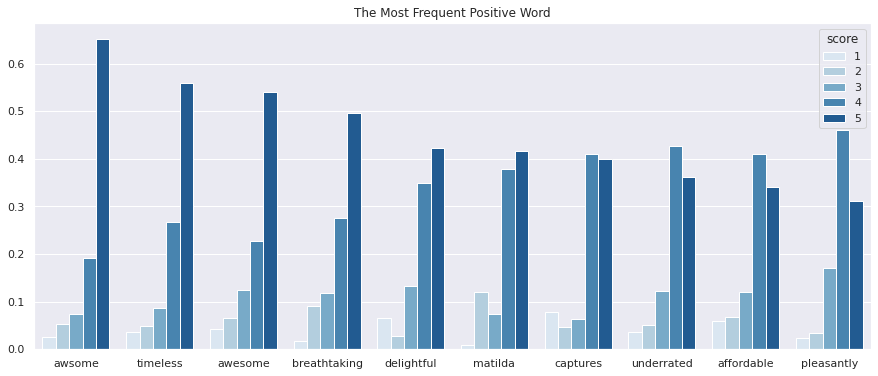

In [9]:
positive_words = list(df_dist.nlargest(10, 'pos_ratio')['text'])
print(len(positive_words), positive_words)

show_frequent_words(positive_words, True)

10 ['waste', 'drivel', 'junk', 'yuck', 'worthless', 'refund', 'redeeming', 'ugh', 'rubbish', 'uninteresting']


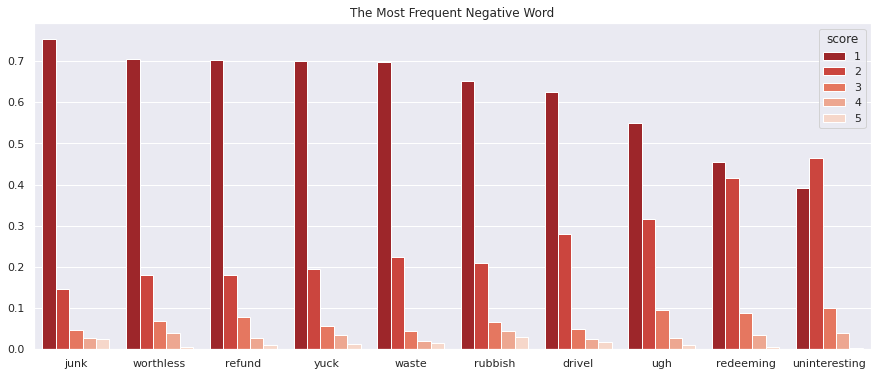

In [10]:
negative_words = list(df_dist.nlargest(10, 'neg_ratio')['text'])
print(len(negative_words), negative_words)

show_frequent_words(negative_words, False)